In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


In [2]:
eurusd = pd.read_csv('/kaggle/input/forex/EURUSD-60-DS.csv')

# دیتافریم‌های جدید
audusd = pd.read_csv('/kaggle/input/forex/AUDUSD-60-DS.csv', header=None, names=['Date', 'Open', 'High', 'Low', 'Close', 'Volume'])
gbpusd = pd.read_csv('/kaggle/input/forex/GBPUSD-60-DS.csv', header=None, names=['Date', 'Open', 'High', 'Low', 'Close', 'Volume'])
usdcad = pd.read_csv('/kaggle/input/forex/USDCAD-60-DS.csv', header=None, names=['Date', 'Open', 'High', 'Low', 'Close', 'Volume'])

for df in [eurusd, audusd, gbpusd, usdcad]:
    df['Date'] = pd.to_datetime(df['Date'], format='%d.%m.%Y %H:%M:%S.%f')

# تنظیم Date به‌عنوان ایندکس
eurusd.set_index('Date', inplace=True)
audusd.set_index('Date', inplace=True)
gbpusd.set_index('Date', inplace=True)
usdcad.set_index('Date', inplace=True)

eurusd = eurusd.add_prefix('EURUSD_')
audusd = audusd.add_prefix('AUDUSD_')
gbpusd = gbpusd.add_prefix('GBPUSD_')
usdcad = usdcad.add_prefix('USDCAD_')
df = eurusd.join([audusd, gbpusd, usdcad], how='inner')


In [3]:
close_columns = ['EURUSD_Open','EURUSD_High','EURUSD_Low','EURUSD_Close', 'AUDUSD_Close', 'GBPUSD_Close', 'USDCAD_Close']
data = df[close_columns].values

In [4]:

# نرمال‌سازی داده‌ها
scalers = {}
for i, col in enumerate(close_columns):
    scaler = MinMaxScaler()
    data[:, i] = scaler.fit_transform(data[:, i].reshape(-1, 1)).flatten()
    scalers[col] = scaler

scaled_data = data
n_features = len(close_columns) 
# تنظیمات
seq_length = 128  # تعداد ساعات گذشته برای ورودی
pred_length = 12  # تعداد ساعات آینده برای پیش‌بینی

# ساخت سکانس‌ها
X, y = [], []
for i in range(seq_length, len(scaled_data) - pred_length):
    X.append(scaled_data[i-seq_length:i])  # سکانس ورودی
    y.append(scaled_data[i:i+pred_length, 3])  # هدف: پیش‌بینی EURUSD_Close

X = np.array(X)
y = np.array(y)

In [5]:
train_size = int(len(X) * 0.8)
val_size = int(len(X) * 0.1)
X_train, X_val, X_test = X[:train_size], X[train_size:train_size + val_size], X[train_size + val_size:]
y_train, y_val, y_test = y[:train_size], y[train_size:train_size + val_size], y[train_size + val_size:]

In [6]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    x = tf.keras.layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = tf.keras.layers.MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(x, x)
    x = tf.keras.layers.Add()([x, inputs])
    y = tf.keras.layers.LayerNormalization(epsilon=1e-6)(x)
    y = tf.keras.layers.Dense(ff_dim, activation="relu")(y)
    y = tf.keras.layers.Dropout(dropout)(y)
    y = tf.keras.layers.Dense(inputs.shape[-1])(y)
    return tf.keras.layers.Add()([y, x])

def transformer_decoder(inputs, encoder_output, head_size, num_heads, ff_dim, dropout=0):
    x = tf.keras.layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = tf.keras.layers.MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(x, x)  # Self-Attention
    x = tf.keras.layers.Add()([x, inputs])
    y = tf.keras.layers.LayerNormalization(epsilon=1e-6)(x)
    y = tf.keras.layers.MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(y, encoder_output)  # Cross-Attention
    y = tf.keras.layers.Add()([y, x])
    z = tf.keras.layers.LayerNormalization(epsilon=1e-6)(y)
    z = tf.keras.layers.Dense(ff_dim, activation="relu")(z)
    z = tf.keras.layers.Dropout(dropout)(z)
    z = tf.keras.layers.Dense(inputs.shape[-1])(z)
    return tf.keras.layers.Add()([z, y])

def build_transformer_model(seq_length, pred_length, n_features, d_model=128, num_heads=8, ff_dim=256, num_encoder_layers=3, num_decoder_layers=3, dropout=0.1):
    # ورودی
    inputs = tf.keras.Input(shape=(seq_length, n_features))
    
    # انکودر
    x = inputs
    for _ in range(num_encoder_layers):
        x = transformer_encoder(x, head_size=d_model, num_heads=num_heads, ff_dim=ff_dim, dropout=dropout)
    
    # دیکودر
    decoder_input = tf.keras.layers.RepeatVector(pred_length)(x[:, -1, :])  # تکرار آخرین timestep انکودر
    y = decoder_input
    for _ in range(num_decoder_layers):
        y = transformer_decoder(y, x, head_size=d_model, num_heads=num_heads, ff_dim=ff_dim, dropout=dropout)
    
    # لایه نهایی برای تولید خروجی
    outputs = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(1))(y)
    
    # ساخت مدل
    model = tf.keras.Model(inputs, outputs)
    model.compile(optimizer='adam', loss=custom_mae_loss,metrics=['mae'])  # استفاده از MAE به جای MSE
    return model

# 3. تنظیم پارامترها و ساخت مدل
d_model = 128
num_heads = 8
ff_dim = 256
num_encoder_layers = 3  # افزایش تعداد لایه‌های انکودر
num_decoder_layers = 3  # افزایش تعداد لایه‌های دیکودر
dropout = 0.1  # اضافه کردن Dropout


def custom_mae_loss(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    abs_error = tf.abs(y_true - y_pred)  # خطای مطلق برای همه timestep‌ها
    # میانگین خطاها فقط روی محور 1 (timestep‌ها)
    return tf.reduce_mean(abs_error, axis=1)  # میانگین روی محور timestep‌ها
    
model = build_transformer_model(seq_length, pred_length, n_features, d_model, num_heads, ff_dim, num_encoder_layers, num_decoder_layers, dropout)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 128, 7)         │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization       │ (None, 128, 7)         │             14 │ input_layer[0][0]      │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention      │ (None, 128, 7)         │         31,751 │ layer_normalization[0… │
│ (MultiHeadAttention)      │                        │                │ layer_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 128, 7)         │              0 │ multi_head_attention[… │
│                           │                        │                │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_1     │ (None, 128, 7)         │             14 │ add[0][0]              │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 128, 256)       │          2,048 │ layer_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_10 (Dropout)      │ (None, 128, 256)       │              0 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 128, 7)         │          1,799 │ dropout_10[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_1 (Add)               │ (None, 128, 7)         │              0 │ dense_1[0][0],         │
│                           │                        │                │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_2     │ (None, 128, 7)         │             14 │ add_1[0][0]            │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention_1    │ (None, 128, 7)         │         31,751 │ layer_normalization_2… │
│ (MultiHeadAttention)      │                        │                │ layer_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_2 (Add)               │ (None, 128, 7)         │              0 │ multi_head_attention_… │
│                           │                        │                │ add_1[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_3     │ (None, 128, 7)         │             14 │ add_2[0][0]            │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 128, 256)       │          2,048 │ layer_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_12 (Dropout)      │ (None, 128, 256)       │              0 │ dense_2[0][0]          │
├──────────────────────

 Total params: 309,059 (1.18 MB)

 Trainable params: 309,059 (1.18 MB)

 Non-trainable params: 0 (0.00 B)

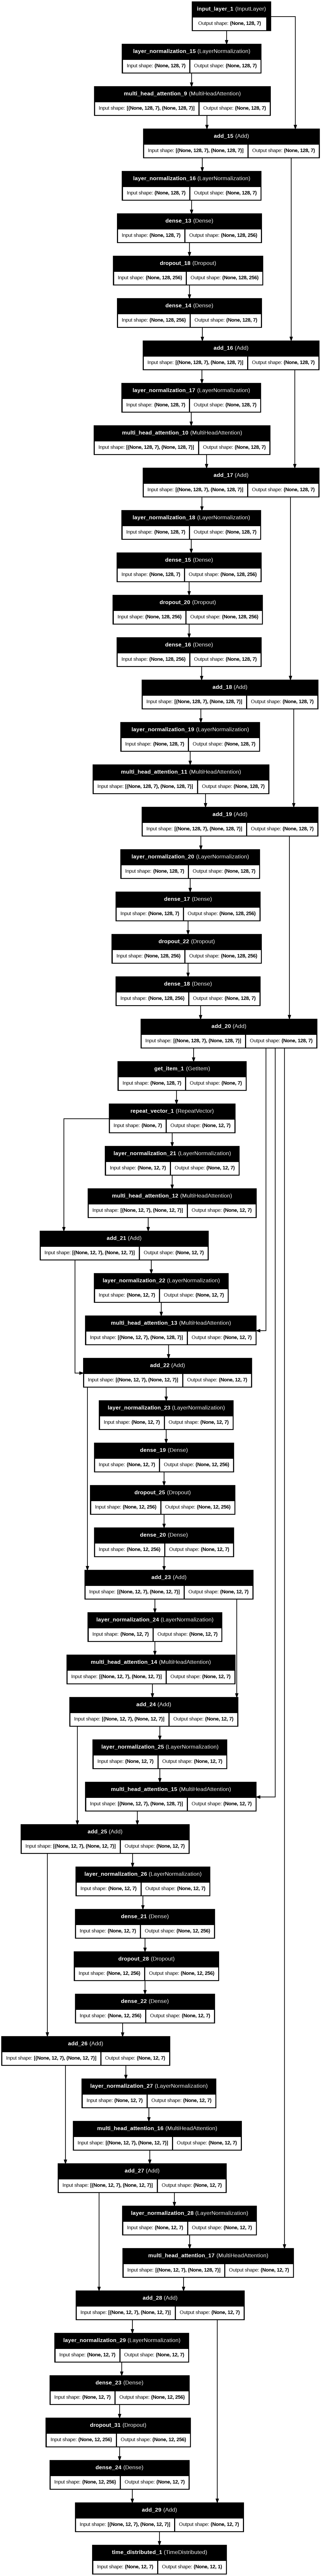

In [8]:
from tensorflow.keras.utils import plot_model

plot_model(model, to_file='model_architecture.png', show_shapes=True, show_layer_names=True, expand_nested=True, dpi=96)

# نمایش مدل (اختیاری، اگه بخوای توی Jupyter Notebook مستقیم نمایش بده)
from IPython.display import Image
Image(filename='model_architecture.png')

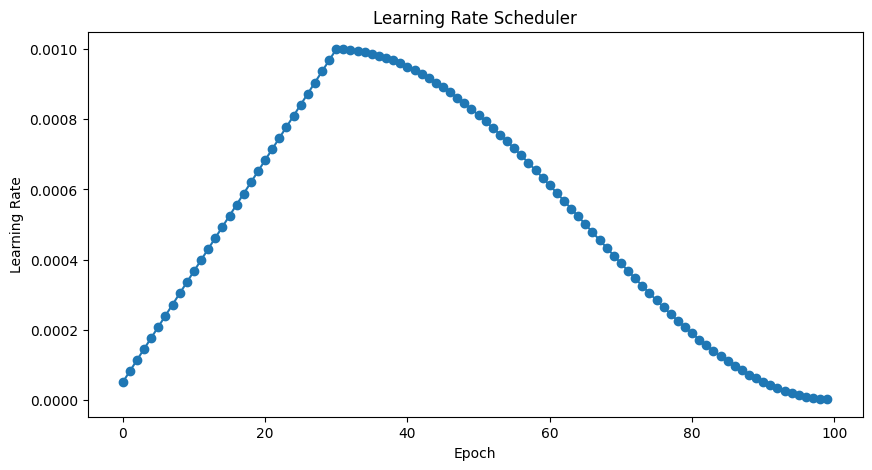


Epoch 1: LearningRateScheduler setting learning rate to 5e-05.
Epoch 1/100
2634/2634 ━━━━━━━━━━━━━━━━━━━━ 123s 33ms/step - loss: 0.1219 - mae: 0.1219 - val_loss: 0.0158 - val_mae: 0.0158 - learning_rate: 5.0000e-05

Epoch 2: LearningRateScheduler setting learning rate to 8.166666666666667e-05.
Epoch 2/100
2634/2634 ━━━━━━━━━━━━━━━━━━━━ 67s 25ms/step - loss: 0.0348 - mae: 0.0348 - val_loss: 0.0106 - val_mae: 0.0106 - learning_rate: 8.1667e-05

Epoch 3: LearningRateScheduler setting learning rate to 0.00011333333333333334.
Epoch 3/100
2634/2634 ━━━━━━━━━━━━━━━━━━━━ 66s 25ms/step - loss: 0.0192 - mae: 0.0192 - val_loss: 0.0123 - val_mae: 0.0123 - learning_rate: 1.1333e-04

Epoch 4: LearningRateScheduler setting learning rate to 0.000145.
Epoch 4/100
2634/2634 ━━━━━━━━━━━━━━━━━━━━ 66s 25ms/step - loss: 0.0155 - mae: 0.0155 - val_loss: 0.0220 - val_mae: 0.0220 - learning_rate: 1.4500e-04

Epoch 5: LearningRateScheduler setting learning rate to 0.00017666666666666666.
Epoch 5/100
2634/2634 

In [7]:
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import tensorflow.keras.backend as K
import math
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

# class CustomMetricsCallback(tf.keras.callbacks.Callback):
#     def __init__(self, X_val, y_val, scaler, forecast_horizon=1):
#         super().__init__()
#         self.X_val = X_val
#         self.y_val = y_val
#         self.scaler = scaler
#         self.forecast_horizon = forecast_horizon

#     def on_epoch_end(self, epoch, logs=None):
#         preds = self.model.predict(self.X_val, verbose=0)
        
#         # تغییر شکل y_val برای inverse_transform
#         n_samples = self.y_val.shape[0]
#         y_val_reshaped = self.y_val.reshape(-1, self.y_val.shape[-1])
        
#         # برگردوندن به مقیاس واقعی
#         preds_real = self.scaler.inverse_transform(preds)
#         y_real = self.scaler.inverse_transform(y_val_reshaped)
        
#         # برگردوندن y_real به شکل اولیه
#         y_real = y_real.reshape(n_samples, self.forecast_horizon, -1)
        
#         # محاسبه متریک‌ها
#         preds_real_flat = preds_real.reshape(-1)
#         y_real_flat = y_real.reshape(-1)
        
#         rmse = mean_squared_error(y_real_flat, preds_real_flat, squared=False)
#         mape = mean_absolute_percentage_error(y_real_flat, preds_real_flat)

#         # محاسبه جهت پیش‌بینی درست
#         direction_acc = None
#         if len(y_real) > 1:  # مطمئن شو که حداقل دو نمونه برای مقایسه وجود داره
#             # برای پیش‌بینی تک‌مرحله‌ای، از مقادیر قبلی تو داده‌های واقعی استفاده می‌کنیم
#             # جهت واقعی: تفاوت بین y_real(t) و y_real(t-1)
#             true_direction = y_real[1:, 0, 0] - y_real[:-1, 0, 0]
#             # جهت پیش‌بینی‌شده: تفاوت بین پیش‌بینی(t) و y_real(t-1)
#             pred_direction = preds_real[1:, 0] - y_real[:-1, 0, 0]
#             direction_acc = (np.sign(true_direction) == np.sign(pred_direction)).mean()
        
#         # چاپ متریک‌ها
#         if direction_acc is not None:
#             print(f"Epoch {epoch+1}: RMSE = {rmse:.5f}, MAPE = {mape:.5f}, Direction Accuracy = {direction_acc:.3%}")
#         else:
#             print(f"Epoch {epoch+1}: RMSE = {rmse:.5f}, MAPE = {mape:.5f}, Direction Accuracy = N/A (not enough samples)")
            

# custom_metrics = CustomMetricsCallback(X_val, y_val, scalers['EURUSD_Close'], forecast_horizon=1)
# # تعریف ReduceLROnPlateau
# reduce_lr = ReduceLROnPlateau(
#     monitor='val_loss',
#     factor=0.25,
#     patience=5,
#     min_lr=1e-6,
#     verbose=1
# )
# تعریف EarlyStopping

def get_lr_callback(batch_size=16, mode='cos', epochs=50, plot=False):
    lr_start, lr_max, lr_min = 0.00005, 0.001, 0.000001
    lr_ramp_ep = int(0.30 * epochs)  # 30% of epochs for warm-up
    lr_sus_ep = max(0, int(0.10 * epochs) - lr_ramp_ep)

    def lrfn(epoch):
        if epoch < lr_ramp_ep:
            lr = (lr_max - lr_start) / lr_ramp_ep * epoch + lr_start
        elif epoch < lr_ramp_ep + lr_sus_ep:
            lr = lr_max
        elif mode == 'cos':
            decay_total_epochs, decay_epoch_index = epochs - lr_ramp_ep - lr_sus_ep, epoch - lr_ramp_ep - lr_sus_ep
            phase = math.pi * decay_epoch_index / decay_total_epochs
            lr = (lr_max - lr_min) * 0.5 * (1 + math.cos(phase)) + lr_min
        else:
            lr = lr_min
        return lr

    if plot:
        plt.figure(figsize=(10, 5))
        plt.plot(np.arange(epochs), [lrfn(epoch) for epoch in np.arange(epochs)], marker='o')
        plt.xlabel('Epoch')
        plt.ylabel('Learning Rate')
        plt.title('Learning Rate Scheduler')
        plt.show()

    return tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=True)
    

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=13,
    restore_best_weights=False,
    start_from_epoch=15,
    verbose=1
)



epochs = 100
lr_scheduler = get_lr_callback(batch_size=32, mode='cos', epochs=epochs, plot=True)
# آموزش مدل
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=32,
    callbacks=[early_stopping, lr_scheduler]
)

330/330 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step


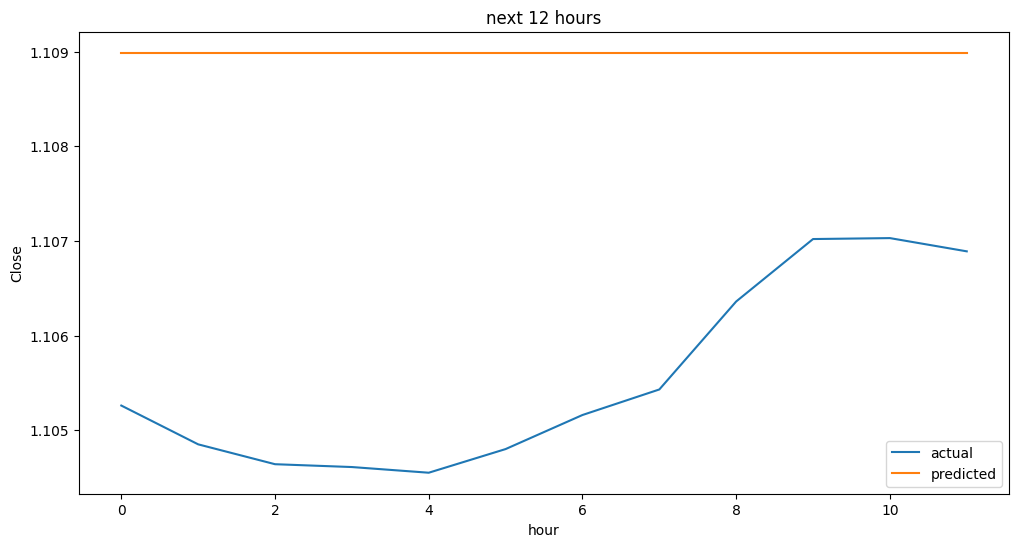

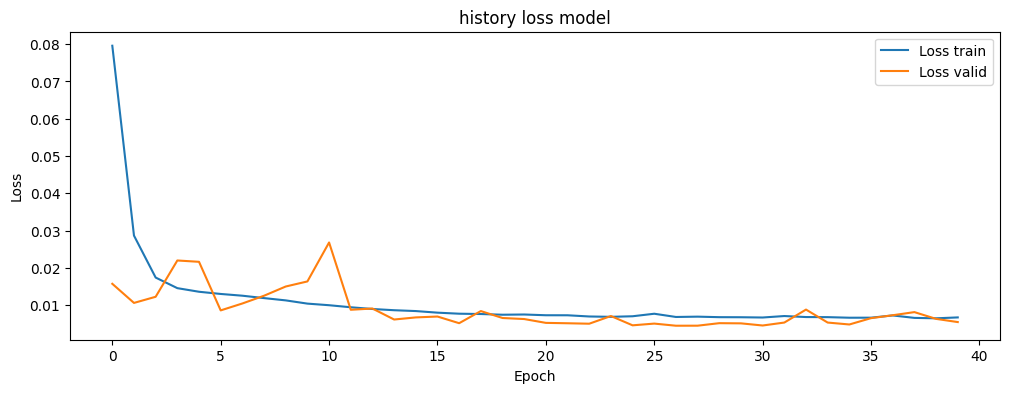

In [8]:

# پیش‌بینی
y_pred = model.predict(X_test)

# معکوس کردن نرمال‌سازی
y_test_inv = scalers['EURUSD_Close'].inverse_transform(y_test.reshape(-1, pred_length))
y_pred_inv = scalers['EURUSD_Close'].inverse_transform(y_pred.reshape(-1, pred_length))

# 4. رسم نتایج
def plot_results(y_test, y_pred, history):
    plt.figure(figsize=(12, 6))
    plt.plot(y_test[0], label='actual')
    plt.plot(y_pred[0], label='predicted')
    plt.title('next 12 hours')
    plt.xlabel('hour')
    plt.ylabel('Close')
    plt.legend()
    plt.show()
    
    plt.figure(figsize=(12, 4))
    plt.plot(history.history['loss'], label='Loss train')
    plt.plot(history.history['val_loss'], label='Loss valid')
    plt.title('history loss model')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# 5. اجرا و ذخیره
plot_results(y_test_inv, y_pred_inv, history)


In [14]:
np.mean(y_test[300])

0.2215542891854049

In [10]:
y_pred[300]

array([[0.22475892],
       [0.22475892],
       [0.22475892],
       [0.22475892],
       [0.22475892],
       [0.22475892],
       [0.22475892],
       [0.22475892],
       [0.22475892],
       [0.22475892],
       [0.22475892],
       [0.22475892]], dtype=float32)

In [11]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
predictions = model.predict(X_test)
predictions_average = scalers['EURUSD_Close'].inverse_transform(predictions.reshape(-1, pred_length))
y_test_average = scalers['EURUSD_Close'].inverse_transform(y_test.reshape(-1, pred_length))
def calculate_metrics(y_true, y_pred, name):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"\nمعیارهای ارزیابی برای {name}:")
    print(f"MSE: {mse:.6f}")
    print(f"RMSE: {rmse:.6f}")
    print(f"MAE: {mae:.6f}")
    print(f"R² Score: {r2:.6f}")

# محاسبه معیارها برای کل داده‌های تست
calculate_metrics(y_test_average, predictions_average, "EURUSD_Close")

330/330 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step

معیارهای ارزیابی برای EURUSD_Close:
MSE: 0.000015
RMSE: 0.003883
MAE: 0.003133
R² Score: 0.946477


330/330 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0053 - mae: 0.0053
330/330 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step


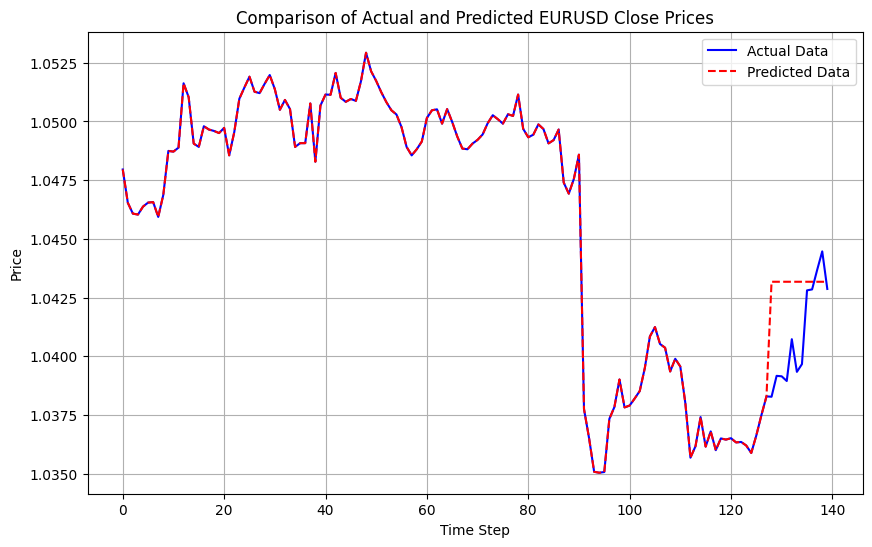

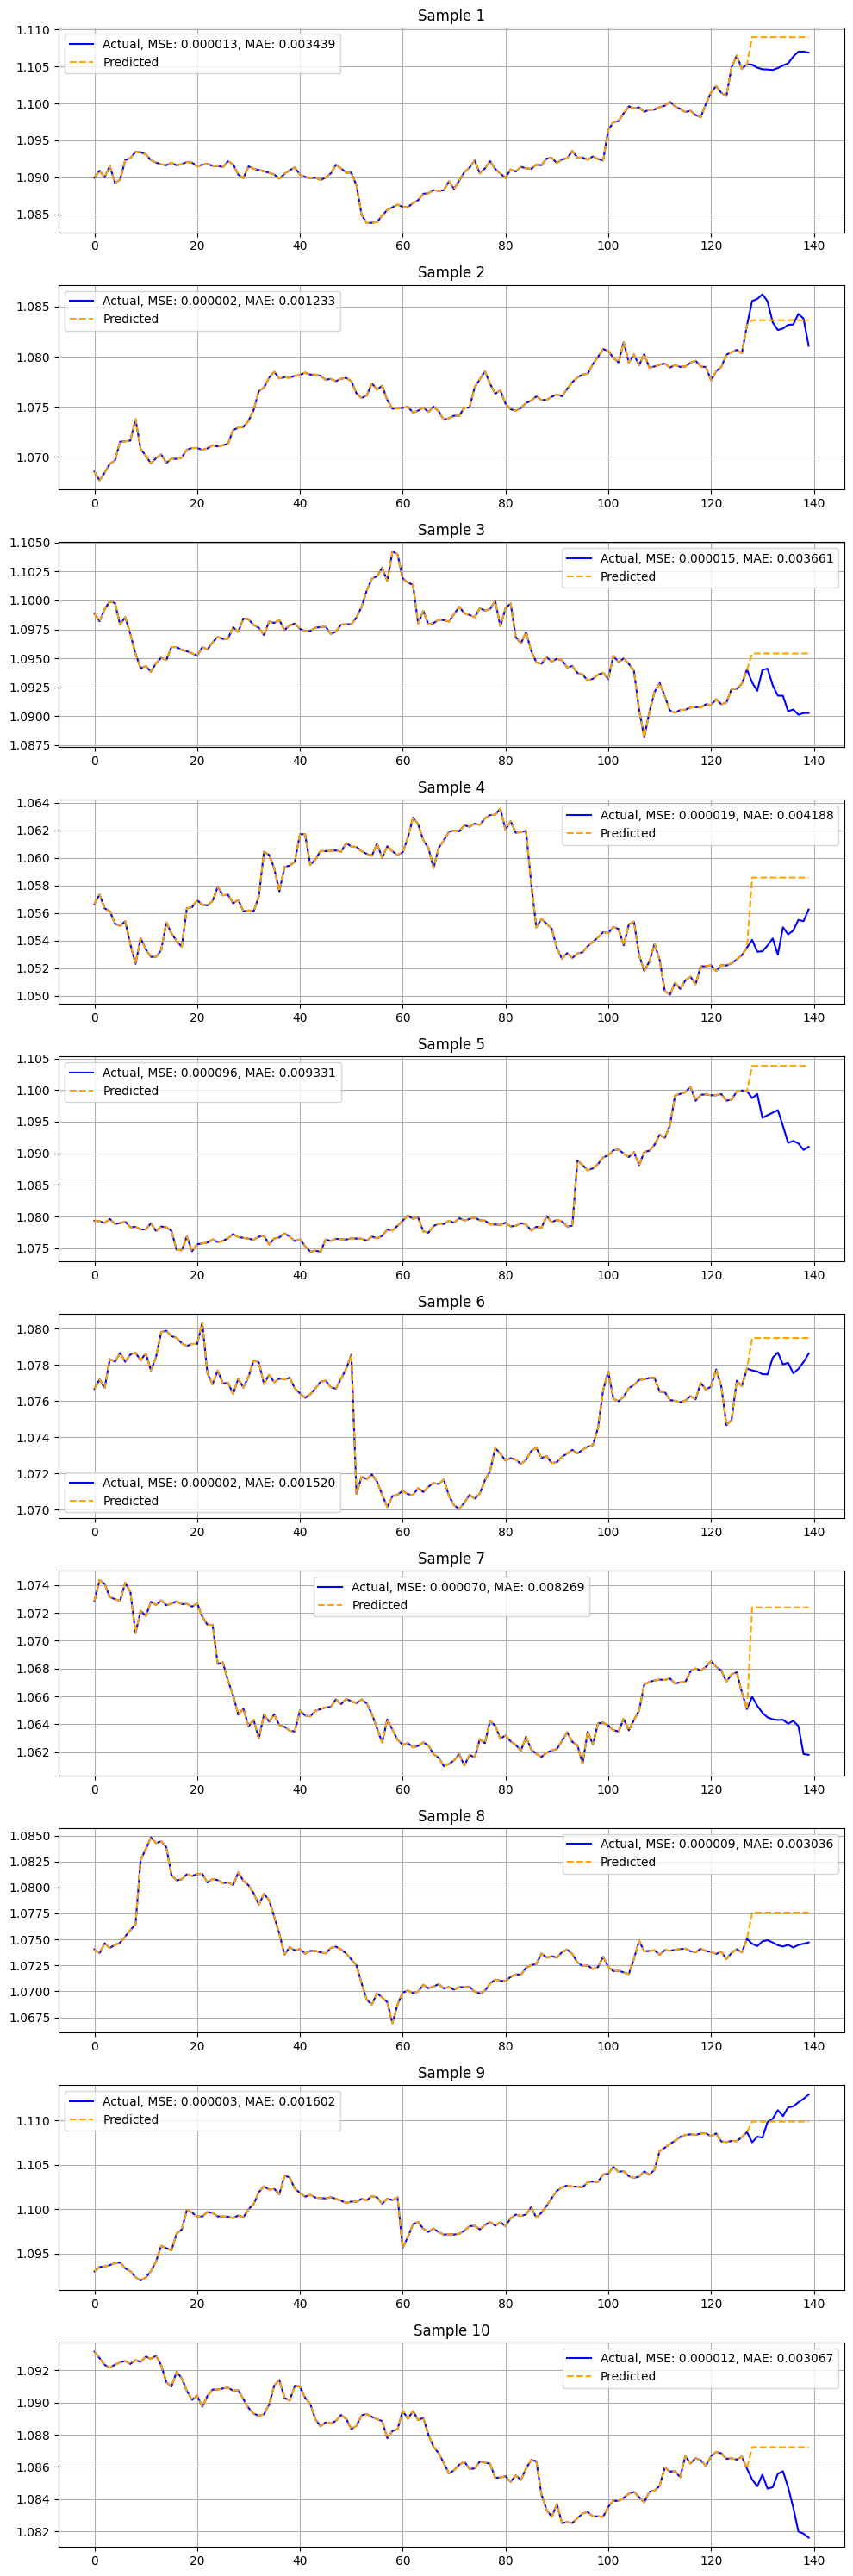

In [12]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

model.evaluate(X_test, y_test, verbose=1)  # ارزیابی کلی مدل
y_pred = model.predict(X_test)

# معکوس کردن نرمال‌سازی برای برگرداندن به مقیاس اصلی
y_test_inv = scalers['EURUSD_Close'].inverse_transform(y_test.reshape(-1, pred_length))
y_pred_inv = scalers['EURUSD_Close'].inverse_transform(y_pred.reshape(-1, pred_length))

# 4. رسم نمودار کلی (مشابه نمودار اول کد بالا)
# برای این کار، داده‌های ورودی (seq_length آخر) و پیش‌بینی‌ها رو کنار هم می‌ذاریم
last_input = X_test[-1, :, 0]  # آخرین سکانس ورودی (فقط EURUSD_Close)
last_input_inv = scalers['EURUSD_Close'].inverse_transform(last_input.reshape(-1, 1)).flatten()
last_true = y_test_inv[-1]  # آخرین داده واقعی
last_pred = y_pred_inv[-1]  # آخرین پیش‌بینی

# ترکیب داده‌های ورودی و پیش‌بینی/واقعی
concatenated_true = np.concatenate((last_input_inv, last_true))
concatenated_pred = np.concatenate((last_input_inv, last_pred))

# رسم
plt.figure(figsize=(10, 6))
plt.plot(concatenated_true, label='Actual Data', color='blue')
plt.plot(concatenated_pred, label='Predicted Data', color='red', linestyle='--')
plt.title('Comparison of Actual and Predicted EURUSD Close Prices')
plt.xlabel('Time Step')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

# 5. رسم چند نمونه (مشابه نمودار دوم کد بالا)
n_samples = 10  # تعداد نمونه‌هایی که می‌خوای رسم کنی
fig, axs = plt.subplots(n_samples, 1, figsize=(10, n_samples * 3))

for i in range(n_samples):
    # انتخاب یه نمونه با فاصله‌های مشخص
    idx = i * (len(X_test) // n_samples)
    sample_input = X_test[idx, :, 0]  # داده ورودی (فقط EURUSD_Close)
    sample_input_inv = scalers['EURUSD_Close'].inverse_transform(sample_input.reshape(-1, 1)).flatten()
    sample_true = y_test_inv[idx]  # داده واقعی
    sample_pred = y_pred_inv[idx]  # پیش‌بینی
    
    # ترکیب داده‌های ورودی و پیش‌بینی/واقعی برای رسم
    sample_true_full = np.concatenate((sample_input_inv, sample_true))
    sample_pred_full = np.concatenate((sample_input_inv, sample_pred))
    
    # محاسبه خطا (MSE)
    mse = mean_squared_error(sample_true, sample_pred)
    mae = mean_absolute_error(sample_true, sample_pred)
    
    # رسم
    axs[i].plot(sample_true_full, label=f'Actual, MSE: {mse:.6f}, MAE: {mae:.6f}', color='blue')
    axs[i].plot(sample_pred_full, label='Predicted', linestyle='--', color='orange')
    axs[i].set_title(f'Sample {i+1}')
    axs[i].legend()
    axs[i].grid(True)

# تنظیم فاصله بین نمودارها
plt.tight_layout()
plt.show()

In [9]:
del model